In [1]:
using PowerSystems, PowerSimulations, InfrastructureSystems, HydroPowerSimulations, PowerSystemCaseBuilder, SiennaPRASInterface, PRASCore
const PSI = PowerSimulations
const PSY = PowerSystems
const IS = InfrastructureSystems

using Gurobi, JuMP

using CSV, DataFrames, Dates, TimeSeries, DataStructures, JSON, Plots, Random, Glob, Printf, Base.Iterators

using Statistics, Distributions, ExpectationMaximization

In [2]:
file_dir = joinpath("/projects", "emco4286", "data", "sienna_data", "input", "DA_sys", "final_sys_DA.json")
sys = System(file_dir)

┌ Info: Loaded time series from storage file existing=/projects/emco4286/data/sienna_data/input/DA_sys/final_sys_DA_time_series_storage.h5 new=/projects/emco4286/code-server/tmp/jl_jXwQKw compression=CompressionSettings(false, CompressionTypes.DEFLATE = 1, 3, true)
└ @ InfrastructureSystems /projects/emco4286/.julia/packages/InfrastructureSystems/LEg3t/src/hdf5_time_series_storage.jl:110
┌ Warning: Invalid range
│   valid_info.struct_name = ThermalStandard
│   field_name = active_power
│   valid_range = active_power_limits
│   valid_info.ist_struct = ThermalStandard(gen-472, true, true, ACBus(7376, CHANNELVIEW 1 10, ACBusTypes.PV = 2, -0.40225807547897185, 1.04, (min = 0.9, max = 1.1), 18.0, Area(Coast, 202.78914140625, 0.0, 0.0, Dict{String, Any}()), LoadZone(4, 43.636300000000006, 12.363500000000004, Dict{String, Any}()), Dict{String, Any}("x" => -95.10269000000001, "y" => 29.802043474614997)), 0.008333408956849222, 0.0, 2.0608130919615197, (min = 0.551, max = 1.8366), (min = -0.2039

Property,Value
Name,
Description,
System Units Base,SYSTEM_BASE
Base Power,100.0
Base Frequency,60.0
Num Components,10247
Type,Count
ACBus,2103
Arc,2834
Area,8


In [3]:
scenario = JSON.parsefile(joinpath("/projects", "emco4286", "data", "scenarios", "medians_99.json"))

Dict{String, Any} with 4 entries:
  "st" => Dict{String, Any}("SILAS_RAY_ST2"=>"/projects/emco4286/data/gads/traj…
  "cc" => Dict{String, Any}("DEER_PARK_ENERGY_CENTER_CC4"=>"/projects/emco4286/…
  "ct" => Dict{String, Any}("WOLF_HOLLOW_1_CC1"=>"/projects/emco4286/data/gads/…
  "gt" => Dict{String, Any}("FREEPORT_LNG_GT3"=>"/projects/emco4286/data/gads/t…

In [5]:
fs_table = PSY.get_forecast_summary_table(sys)
it = DateTime(fs_table[1, :initial_timestamp])
resolution = convert(Hour, fs_table[1, :resolution])
intervals = fs_table[1, :interval]
num_intervals = fs_table[1, :window_count]
ft = it .+ convert(Day, intervals) .* num_intervals
ts_timestamps = collect(StepRange(it, resolution, ft))

for k1 in collect(keys(scenario))
    for k2 in collect(keys(scenario[k1]))

        gen = get_component(ThermalMultiStart, sys, k2)

        if gen == nothing
            gen = get_component(ThermalStandard, sys, k2)
        end
        
        ts_forced_outage = PSY.TimeSeriesForcedOutage(outage_status_scenario="WorstShortfallSample")
        PSY.add_supplemental_attribute!(sys, gen, ts_forced_outage)

        df = DataFrame(CSV.File(scenario[k1][k2], select=[:state]))
        data = Bool.(df.state)

        availability_data = TimeSeries.TimeArray( ts_timestamps,data)
        availability_timeseries = PSY.SingleTimeSeries("availability", availability_data)
        PSY.add_time_series!(sys, ts_forced_outage, availability_timeseries)

        if !has_supplemental_attributes(gen)
            print(k1)
            print(k2)
            break
        end
    end
end
        

In [15]:
collect(keys(scenario))

4-element Vector{String}:
 "st"
 "cc"
 "ct"
 "gt"

In [18]:
k1 = "st"
k2 = collect(keys(scenario[k1]))[1]
PSY.add_supplemental_attribute!(sys, gen, ts_forced_outage)

df = DataFrame(CSV.File(scenario[k1][k2], select=[:state]))
data = Bool.(df.state)

availability_data = TimeSeries.TimeArray( ts_timestamps,data)
availability_timeseries = PSY.SingleTimeSeries("availability", availability_data)
PSY.add_time_series!(sys, ts_forced_outage, availability_timeseries)


ArgumentError: ArgumentError: There is already an association between ThermalMultiStart: WA_PARISH_STG_U6 and TimeSeriesForcedOutage: dc5ef4a1-b168-415c-9f01-104505a18f1a

In [10]:
gen = get_component(ThermalMultiStart, sys, "SILAS_RAY_ST2")

ThermalMultiStart: SILAS_RAY_ST2:
   name: SILAS_RAY_ST2
   available: true
   status: true
   bus: ACBus: BROWNSVILLE 1 0
   active_power: 0.00834375
   reactive_power: 0.0
   rating: 2.9760000000000004
   prime_mover_type: PrimeMovers.ST = 20
   fuel: ThermalFuels.NATURAL_GAS = 7
   active_power_limits: (min = 0.801, max = 2.67)
   reactive_power_limits: (min = -0.08960000000000001, max = 1.344)
   ramp_limits: (up = 0.016, down = 0.02432)
   power_trajectory: (startup = 2.136, shutdown = 1.335)
   time_limits: (up = 2.0, down = 4.0)
   start_time_limits: (hot = 0.0, warm = 4.0, cold = 48.0)
   start_types: 1
   operation_cost: ThermalGenerationCost composed of variable: CostCurve{LinearCurve}
   base_power: 320.0
   services: 0-element Vector{Service}
   time_at_status: 8760.0
   must_run: false
   dynamic_injector: nothing
   ext: Dict{String, Any}("ERCOT_FUEL" => "Missing")
   InfrastructureSystems.SystemUnitsSettings:
      base_value: 100.0
      unit_system: UnitSystem.SYSTEM_B

In [13]:
has_supplemental_attributes(gen)

false

In [11]:
ts = get_supplemental_attributes(gen)

SupplementalAttribute[]

In [108]:
collect(get_time_series_multiple(ts))
my_time_series = get_time_series_array(SingleTimeSeries, ts, "availability")

8761×1 TimeArray{Bool, 1, DateTime, Vector{Bool}} 2018-01-01T00:00:00 to 2019-01-01T00:00:00
┌─────────────────────┬──────┐
│                     │ A    │
├─────────────────────┼──────┤
│ 2018-01-01T00:00:00 │ true │
│ 2018-01-01T01:00:00 │ true │
│ 2018-01-01T02:00:00 │ true │
│ 2018-01-01T03:00:00 │ true │
│ 2018-01-01T04:00:00 │ true │
│ 2018-01-01T05:00:00 │ true │
│ 2018-01-01T06:00:00 │ true │
│ 2018-01-01T07:00:00 │ true │
│          ⋮          │  ⋮   │
│ 2018-12-31T18:00:00 │ true │
│ 2018-12-31T19:00:00 │ true │
│ 2018-12-31T20:00:00 │ true │
│ 2018-12-31T21:00:00 │ true │
│ 2018-12-31T22:00:00 │ true │
│ 2018-12-31T23:00:00 │ true │
│ 2019-01-01T00:00:00 │ true │
└─────────────────────┴──────┘
             8746 rows omitted

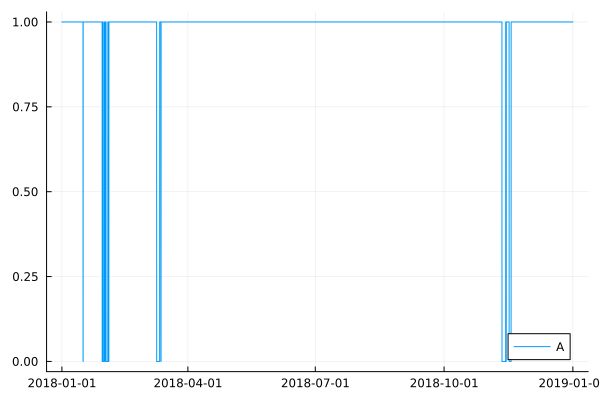

In [109]:
plot(my_time_series)